In [145]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, Flatten
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import time
import itertools
import re
import seaborn as sns

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
!pip install tweepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 340.4 kB/s eta 0:00:00a 0:00:01


In [3]:
import tweepy

In [206]:
#twitter API credentials
consumerKey = "V0AbktVHuciimTCOXSgU7Zbfc"
consumerSecret = "mREamg9BsZoJsIZNwDORE50GS7ZqWM9uAz5roornoIxj46xCgR"
accessToken = "1190269761948663809-ucGSjbsNsAaWerbXotnidWkEaxdc3M"
accessTokenSecret = "1vRd2O2IlGxeLc9BEc2zrimB8q0yCukFUHq7Mx5zSRbiG"

#create authentication object
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret)
#Set access token and access token secret
authenticate.set_access_token(accessToken, accessTokenSecret)
#Create the API object while passing in the auth info
api = tweepy.API(authenticate)

#extract 10 tweets
posts = api.user_timeline(screen_name = "BillGates", count = 10, lang = "en", tweet_mode="extended")
for tweet in posts:
    print(tweet.full_text + '\n')
    


        

I am in awe of people who have dedicated their lives to making the world a more equitable place, and I feel lucky to be able to support their efforts. https://t.co/It4s0WRzH5

You don’t need to be a big soccer fan to recognize why it’s called “the beautiful game.” https://t.co/Bkiar7eYUu

RT @gatesfoundation: This is a major milestone in the fight against #malaria. Now, millions more people have access to a powerful new tool…

RT @AP: The major advance in fusion research announced on  Tuesday was decades in coming, with scientists for the first time able to engine…

In order to solve our world’s sanitation crisis, we need smarter toilets that don’t rely on sewage systems and prevent the spread of diseases. #WorldToiletDay https://t.co/gbp9F0GxlE

Collaboration and more open access to data have made seemingly impossible health breakthroughs a reality, like COVID-19 vaccines. @AlzData is putting the power of data behind one of our most critical health challenges. https://t.co/Qtatf2WMds


In [5]:
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', encoding = 'latin', header = None)
df.head(10)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [6]:
df.columns = ['sentiment', 'ID', 'date', 'query', 'username', 'tweet']
df.head()

,sentiment,ID,date,query,username,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
data = df.drop(['ID', 'date', 'query', 'username'], axis = 1)
sent = { 0: 'Negative', 4: 'Positive'}
def label_decoder(label):
    return sent[label]

data.sentiment = data.sentiment.apply(lambda x : label_decoder(x))
data.head()

,sentiment,tweet
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Negative    800000
Positive    800000
Name: sentiment, dtype: int64


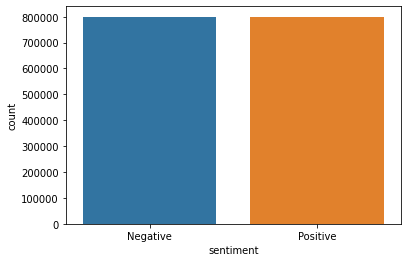

In [8]:
plt.figure()
sns.countplot(data['sentiment'])
print(data['sentiment'].value_counts())

In [198]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
text_cleaning_re = '@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+'

def preprocess(text, stem = False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    text = re.sub(r'<3', '<heart>', text)
    text = re.sub(r"[8:=;]['`\-]?[)d]+", '<smile>', text)
    text = re.sub(r"[8:=;]['`\-]?\(+", '<sadface>', text)
    text = re.sub(r"[8:=;]['`\-]?[\/|l*]", '<neutralface>', text)
    text = re.sub(r"[8:=;]['`\-]?p+", '<lolface>', text)
    text = re.sub("[^a-z0-9<>]", ' ', text)
    tokens =[]
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return ' '.join(tokens)

In [199]:
data.tweet[24821]

'say quot got 16gb flashdrive quot says quot saw 64gb flashdrive quot somehow statement trumps mine'

In [200]:
preprocess(data.tweet[24821], True)

'say quot got 16gb flashdriv quot say quot saw 64gb flashdriv quot somehow statement trump mine'

In [22]:
data.tweet = data.tweet.apply(lambda x : preprocess(x))
data.head()

,sentiment,tweet
0,Negative,awww bummer shoulda got david carr third day
1,Negative,upset update facebook texting might cry result...
2,Negative,dived many times ball managed save 50 rest go ...
3,Negative,whole body feels itchy like fire
4,Negative,behaving mad see


In [158]:
data = shuffle(data)
searchWords = '|'.join(['sport', 'player', 'game', 'ball'])
filtered = data[data['tweet'].str.contains(searchWords, case=False)]
pd.set_option('display.max_colwidth', 0)
print("Amount of positive tweets:", filtered['sentiment'].value_counts()['Positive'])
print("Amount of negative tweets:", filtered['sentiment'].value_counts()['Negative'])
filtered.head()

Amount of positive tweets: 10756
Amount of negative tweets: 11506


,sentiment,tweet
862863,Positive,heading sleep cottonball drenched rubbing alcohol taped face eh im trippin quot fml quot abbreviations apply ttyl
1584828,Positive,sports funny faces
206401,Negative,back soccer game lost
1529386,Positive,hear hear yay statistical analysis wrote demo script friend making rp gamemode show show stats
1251958,Positive,game worth buying decided yet


In [159]:
searchWords = '|'.join(['Obama', 'Trump', 'politics', 'president', 'election'])
filtered2 = data[data['tweet'].str.contains(searchWords, case=False)]
print("Amount of positive tweets:", filtered2['sentiment'].value_counts()['Positive'])
print("Amount of negative tweets:", filtered2['sentiment'].value_counts()['Negative'])
pd.set_option('display.max_colwidth', 0)
filtered2.head(10)

Amount of positive tweets: 978
Amount of negative tweets: 1209


,sentiment,tweet
1247706,Positive,say good birthday jennifer pleaaaase president thuse time please
359134,Negative,favorite wish would president
1574764,Positive,btw turned incredible hulk feel little solidarity iranian brothers sisters iranelection
372637,Negative,missing tehran election days
580930,Negative,hope obama elected though lot countries would disappointed
1276369,Positive,hehe ijump suggests quot mean trump quot amp link shows donald trump great suggestion reckon lmao
1521486,Positive,aye gone green support iranelections
1311903,Positive,obama list lol
961965,Positive,djing american politics collectively twitter poli geeks must poli palooza online
1291257,Positive,believe find channels prodcasting sports channels league days obama egypt sadekhm


In [201]:
processedtext = list(data.tweet)
data_pos = processedtext[800000:]
data_neg = processedtext[:800000]

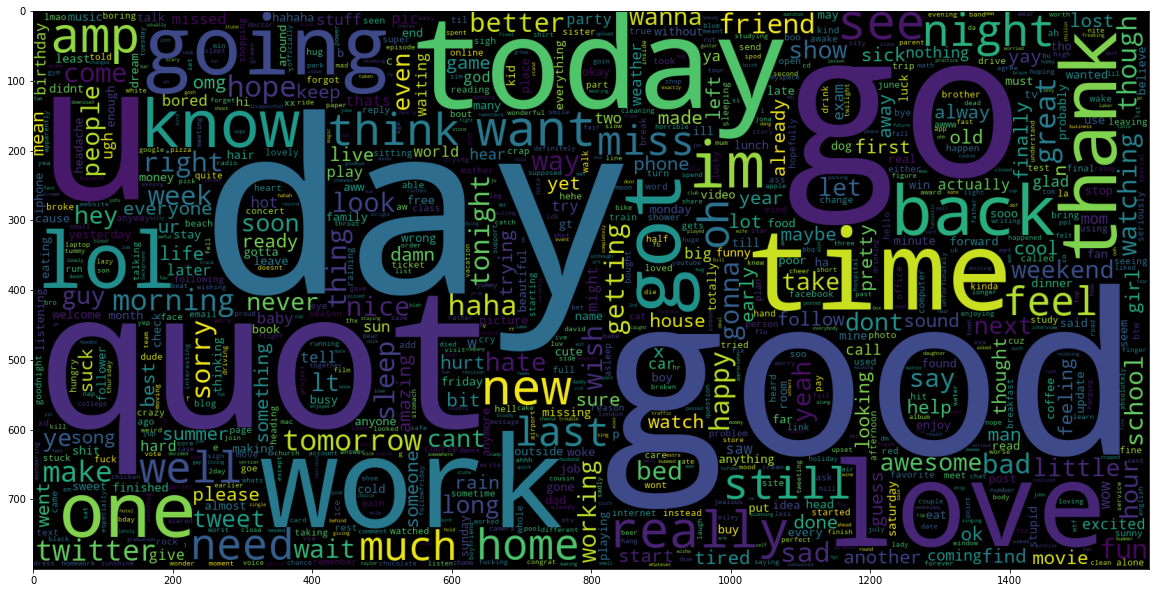

In [202]:
word_cloud = WordCloud(max_words = 1000 , width = 1000 , height = 600,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(word_cloud)

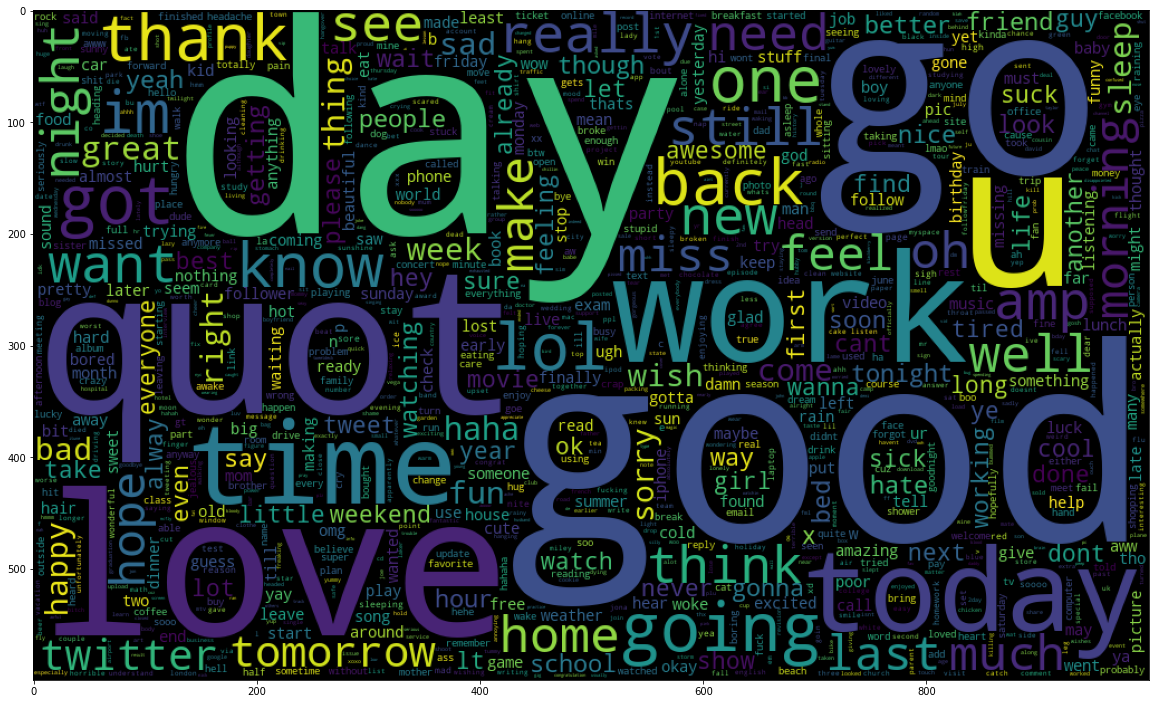

In [205]:
wc = WordCloud(max_words = 1000 , width = 1000 , height = 600,
              collocations=False).generate(" ".join(data_neg))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [27]:
Train_size = 0.8
max_words = 100000
max_length = 30

In [28]:
train_data, test_data = train_test_split(data, test_size = 1 - Train_size, random_state = 5)
print('size of training data :', len(train_data))
print('size of testing data :',len(test_data))

size of training data : 1280000
size of testing data : 320000


In [29]:
train_data.head()

,sentiment,tweet
887460,Positive,ahaha honestly im even tired suprise woke sooo...
545899,Negative,wtf goldfish hate keep dying poor
835785,Positive,serious finish things
277841,Negative,come think one one tanga ako
1124354,Positive,started following mind direct messaging tell know


In [30]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.tweet)

word_index = tokenizer.word_index
vocab_size = len(word_index)
print('VOCAB_SIZE :', vocab_size)

VOCAB_SIZE : 290739


In [31]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.tweet), maxlen = max_length)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.tweet), maxlen = max_length)

print('training x shape :', x_train.shape)
print('testing x shape :', x_test.shape)

training x shape : (1280000, 30)
testing x shape : (320000, 30)


In [32]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.tolist())
y_test = encoder.transform(test_data.sentiment.tolist())

print('y_train shape :', y_train.shape)
print('y_test shape :', y_test.shape)

y_train shape : (1280000,)
y_test shape : (320000,)


In [33]:
y_train = y_train.reshape(1280000,1)
y_test = y_test.reshape(320000,1)

print('y_train shape :', y_train.shape)
print('y_test shape :', y_test.shape)

y_train shape : (1280000, 1)
y_test shape : (320000, 1)


In [34]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-01-08 16:58:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-01-08 16:58:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-08 16:58:02--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [35]:
GLOVE_EMB = './glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 12
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [36]:
embeddings_index = {}
file = open(GLOVE_EMB)
for line in file:
    values = line.split()
    word = value = values[0]
    coef = np.asarray(values[1:],dtype = 'float32')
    embeddings_index[word] = coef
    
file.close()
print('Found {} word vectors'.format(len(embeddings_index)))

Found 400000 word vectors


In [37]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [39]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                           EMBEDDING_DIM,
                                           weights = [embedding_matrix],
                                           input_length = max_length,
                                           trainable = False)

In [40]:
sequence_input = Input(shape = (max_length), dtype = 'int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation = 'relu')(x)
x = Bidirectional(LSTM(64, dropout = 0.2, recurrent_dropout = 0.2))(x)
x = Dense(512, activation = 'relu')(x)
# x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

2023-01-08 17:03:54.001409: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 17:03:54.104060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 17:03:54.104862: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 17:03:54.106325: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [41]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 300)           87221700  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 30, 300)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 26, 64)            96064     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

In [42]:
model.compile(optimizer = Adam(learning_rate = LR),
             loss ='binary_crossentropy',
             metrics = ['accuracy'])

LR_reduction = ReduceLROnPlateau(factor = 0.1,
                                min_lr = 0.0001,
                                monitor = 'val_loss',
                                verbose = 1)

In [43]:
history = model.fit(x_train,
                   y_train,
                   batch_size = BATCH_SIZE,
                   epochs = EPOCHS,
                   validation_data = (x_test, y_test),
                   callbacks = [LR_reduction])

2023-01-08 17:04:12.552864: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 153600000 exceeds 10% of free system memory.
2023-01-08 17:04:12.746499: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/12


2023-01-08 17:04:16.558475: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1250/1250 [==============================] - ETA: 0s - loss: 0.5190 - accuracy: 0.7394

2023-01-08 17:06:24.703112: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 38400000 exceeds 10% of free system memory.


1250/1250 [==============================] - 137s 102ms/step - loss: 0.5190 - accuracy: 0.7394 - val_loss: 0.4816 - val_accuracy: 0.7662
Epoch 2/12
1250/1250 [==============================] - 126s 101ms/step - loss: 0.4877 - accuracy: 0.7620 - val_loss: 0.4722 - val_accuracy: 0.7722
Epoch 3/12
1250/1250 [==============================] - 127s 102ms/step - loss: 0.4773 - accuracy: 0.7689 - val_loss: 0.4671 - val_accuracy: 0.7751
Epoch 4/12
1250/1250 [==============================] - 127s 102ms/step - loss: 0.4708 - accuracy: 0.7730 - val_loss: 0.4649 - val_accuracy: 0.7767
Epoch 5/12
1250/1250 [==============================] - 127s 102ms/step - loss: 0.4667 - accuracy: 0.7759 - val_loss: 0.4624 - val_accuracy: 0.7785
Epoch 6/12
1250/1250 [==============================] - 131s 105ms/step - loss: 0.4631 - accuracy: 0.7778 - val_loss: 0.4609 - val_accuracy: 0.7795
Epoch 7/12
1250/1250 [==============================] - 130s 104ms/step - loss: 0.4602 - accuracy: 0.7795 - val_loss: 0.459

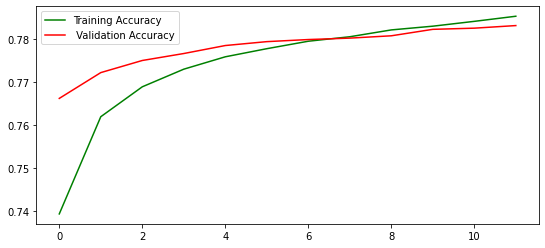

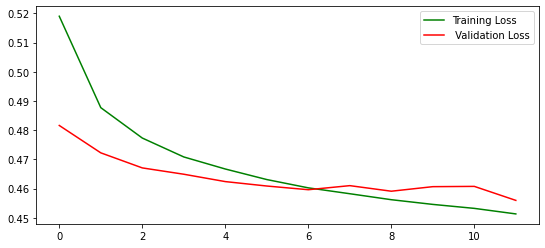

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))


plt.figure(figsize = (9,4))
plt.plot(acc, color = 'green', label = 'Training Accuracy')
plt.plot(val_acc, color = 'red', label = ' Validation Accuracy')
plt.legend()

plt.figure(figsize= (9,4))
plt.plot(loss,color = 'green', label = 'Training Loss')
plt.plot(val_loss, color = 'red', label = ' Validation Loss')
plt.legend()

In [48]:
def decode_sentiment(score):
    if score > 0.6:
            return 'Positive'
    elif (score > 0.5 and score < 0.6):
            return 'Neutral'
    else:
            return'Negative'

scores = model.predict(x_test, verbose = 1, batch_size = 10000)
y_pred_D = [decode_sentiment(score) for score in scores]

2023-01-08 18:04:30.106912: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 38400000 exceeds 10% of free system memory.


32/32 [==============================] - 2s 39ms/step


In [211]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
  """
  This Function prints and plots the Confusion Matrix.
  Normalization can be applied by setting 'normalize=true'.
  """
  plt.imshow(cm, interpolation = 'nearest', cmap =cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes,rotation = 30)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm= cm.astype('float')/ cm.sum(axis = 1[:, np.newaxis])
    print("Normalized Confusion Matrix")
  else:
    print('Confusion matrix, without Normalization')

  #print(cm)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment= 'center',
             color = "white" if cm[i,j]>thresh else "black")
    
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('predicted label')

Confusion matrix, without Normalization


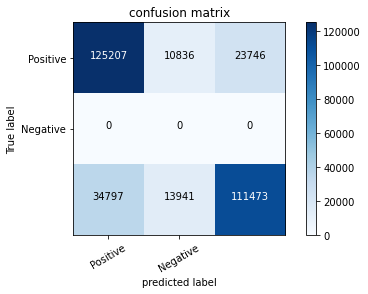

In [212]:
cnf_matrix = confusion_matrix(test_data.sentiment.tolist(), y_pred_D)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = test_data.sentiment.unique(), title = 'confusion matrix')
plt.show()

In [51]:
accuracy = max(acc)
print('Accuracy of model :', accuracy)

Accuracy of model : 0.7853624820709229


In [52]:
print(classification_report(list(test_data.sentiment), y_pred_D))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    Negative       0.78      0.78      0.78    159789
     Neutral       0.00      0.00      0.00         0
    Positive       0.82      0.70      0.75    160211

    accuracy                           0.74    320000
   macro avg       0.54      0.49      0.51    320000
weighted avg       0.80      0.74      0.77    320000



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
def pred(text):
    start_at = time.time()
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=max_length) 
    score = model.predict([x_test])[0]
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [192]:
posts = api.user_timeline(screen_name = "elonmusk", count = 5, lang = "en", tweet_mode="extended")
#clean_tweet = preprocess(tweet.full_text,True)
sums = 0.
counter = 0
pos = 0
neg = 0
neu = 0
print('--------Tweets: ')
print('\n')
for tweet in posts:
    print(tweet.full_text)
    prediction =pred(tweet.full_text)
    
    temp =prediction.get('score')
    sums += temp
    counter += 1
    
    temp2 =prediction.get('label')
    if temp2 == 'Positive':
        pos +=1
    elif temp2 == 'Negative':
        neg +=1
    else:
        neu +=1
    print(prediction)    
    print('\n')
print('---------------------------------------------------------------------------------------')
print('There are '+ str(pos)+' positive tweets, '+str(neg) +' negative tweets, and '+str(neu) +' neutral tweets')   
avg = sums/counter
print('The average score of all the retrieved tweets is ' +str(avg))
if avg > 0.6:
    print('The final grade is therefore positive')
elif (avg > 0.5 and avg < 0.6):
    print('The final grade is therefore neutral')
else:
    print('The final grade is therefore negative')

--------Tweets: 


Easy swipe right/left to move between recommended vs followed tweets rolls out later this week.

First part of a much larger UI overhaul.

Bookmark button (de facto silent like) on Tweet details rolls out a week later.

Long form tweets early Feb.
{'label': 'Negative', 'score': 0.3326614499092102, 'elapsed_time': 0.06985783576965332}


@WholeMarsBlog We have a real shot at late February.  March launch attempt appears highly likely.
{'label': 'Negative', 'score': 0.4576491415500641, 'elapsed_time': 0.052992820739746094}


@DavidSacks It will go lower
{'label': 'Negative', 'score': 0.31749477982521057, 'elapsed_time': 0.045928239822387695}


@PeterDiamandis Risky Business (great movie)
{'label': 'Positive', 'score': 0.8510878682136536, 'elapsed_time': 0.04586076736450195}


@BillyM2k 🤣
{'label': 'Neutral', 'score': 0.5731717944145203, 'elapsed_time': 0.04330706596374512}


---------------------------------------------------------------------------------------
There are

In [195]:
search_term = '|'.join(['sport', 'player', 'game', 'ball'])
tweet_amount = 5
sums = 0.
counter = 0
pos = 0
neg = 0
neu = 0
tweets = tweepy.Cursor(api.search_tweets, q = search_term, lang = 'en').items(tweet_amount)
print('--------Tweets: ')
print('\n')
for tweet in tweets:
    print(tweet.text)
    prediction =pred(tweet.text)
    
    temp =prediction.get('score')
    sums += temp
    counter += 1
    
    temp2 =prediction.get('label')
    if temp2 == 'Positive':
        pos +=1
    elif temp2 == 'Negative':
        neg +=1
    else:
        neu +=1
    print(prediction)    
    print('\n')
print('---------------------------------------------------------------------------------------')
print('There are '+ str(pos)+' positive tweets, '+str(neg) +' negative tweets, and '+str(neu) +' neutral tweets')   
avg = sums/counter
print('The average score of all the retrieved tweets is ' +str(avg)) 
if avg > 0.6:
    print('The final grade is therefore positive')
elif (avg > 0.5 and avg < 0.6):
    print('The final grade is therefore neutral')
else:
    print('The final grade is therefore negative')

--------Tweets: 


@ricknasty629 @NFL_DovKleiman is hillis a 24 yr old current sport ball player who had cardiac arrest mid game? just… https://t.co/rFVG89XUoC
{'label': 'Neutral', 'score': 0.5780087113380432, 'elapsed_time': 0.05342459678649902}


RT @videolib_store: American Football
https://t.co/kfoH9NvSJj

#american #ball #defense #down #football #game #goalpost #gridiron #offense…
{'label': 'Positive', 'score': 0.7030212879180908, 'elapsed_time': 0.04950070381164551}


American Football
https://t.co/kfoH9NvSJj

#american #ball #defense #down #football #game #goalpost #gridiron… https://t.co/2dGctlBHM0
{'label': 'Positive', 'score': 0.6670459508895874, 'elapsed_time': 0.05536937713623047}


Football Allstars (Soccer)
https://t.co/vk6bZPKXhg

#3d #ball #cinema4dtemplates #display #football #game #intro… https://t.co/owVMlRi8W7
{'label': 'Positive', 'score': 0.7461287379264832, 'elapsed_time': 0.050972700119018555}


RT @67_Celtic_1888: @chris_sutton73 @Record_Sport It was a penalty…

In [197]:
client = tweepy.Client(bearer_token = 'AAAAAAAAAAAAAAAAAAAAADvCkQEAAAAAqBldguiK%2FewFmwE1Cpd1UbQrlew%3D4Ysvdx21ITFfLHDHTL5nnV8q5KCNJ8dOLrYf23yIE8S3OOnCvw')
query = '#cars -is:retweet lang:en'
tweets = client.search_recent_tweets(query=query, tweet_fields=['context_annotations', 'created_at'], max_results=10)
sums = 0.
counter = 0
pos = 0
neg = 0
neu = 0
for tweet in tweets.data:
    print(tweet.text)
    prediction =pred(tweet.text)
    
    temp =prediction.get('score')
    sums += temp
    counter += 1
    
    temp2 =prediction.get('label')
    if temp2 == 'Positive':
        pos +=1
    elif temp2 == 'Negative':
        neg +=1
    else:
        neu +=1
    print(prediction)    
    print('\n')
print('---------------------------------------------------------------------------------------')
print('There are '+ str(pos)+' positive tweets, '+str(neg) +' negative tweets, and '+str(neu) +' neutral tweets')   
avg = sums/counter
print('The average score of all the retrieved tweets is ' +str(avg)) 
if avg > 0.6:
    print('The final grade is therefore positive')
elif (avg > 0.5 and avg < 0.6):
    print('The final grade is therefore neutral')
else:
    print('The final grade is therefore negative')

Just thought I’d share this great photo from #Havana #Cuba 
Eclectic #classiccars #cars Amazing city of history https://t.co/p6FoKeWY4Z
{'label': 'Positive', 'score': 0.8982456922531128, 'elapsed_time': 0.046872854232788086}


From the 2009 Frankfurt Auto Show. Some of the most beautiful demos on show were never actually manufactured.

#cars #Frankfurt #autoshow #timetravel https://t.co/gXwKKuSBo0
{'label': 'Neutral', 'score': 0.5062010288238525, 'elapsed_time': 0.04349994659423828}


Who has better suspension? 🌉

📷: @dk.supra

💥 Tag @toyotaofkirkland on Instagram for an opportunity to be featured on our page or IG story.
.
.
.
#happynewyear #newyear #supra #gr #grsupra #toyotasupra #mk5 #mkv #mkvsupra #cars #jdm #jdmgram #jdmlife #jdmdaily #supranation https://t.co/QZqbbFy72W
{'label': 'Positive', 'score': 0.6663676500320435, 'elapsed_time': 0.043164968490600586}


Looking to ship your SUV?! 
Give us a call today to speak with one of our skilled shipping experts! 1-888-885-9123 x  Sal